### Introduction to GANs
by Santiago VELASCO-FORERO \\
Generative Adversarial Networks \\
In this TP we study an implementation of Conditional GANs.

In [1]:
!pip install celluloid

In [2]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
plt.gray()

# For plotting
from IPython.display import HTML
from base64 import b64encode

<Figure size 640x480 with 0 Axes>

In [3]:
from celluloid import Camera

def save_animation(vname, interval=30):
  anim = camera.animate(blit=True, interval=interval)
  anim.save(vname)

def show_video(vname):
  mp4 = open(vname,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

Text(0.5, 1.0, 'Example of Class Embedding')

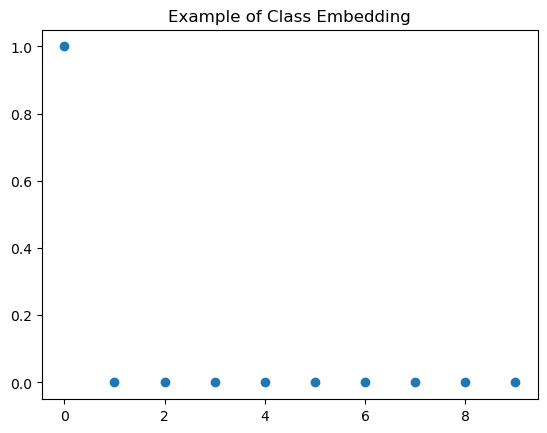

In [4]:
batch_size = 64
num_channels = 1
num_classes = 10
latent_dim = 12
generator_in_channels = latent_dim

# Simple Class embedding
dim_class_embeeding=10
def get_class_embedding(classsteps, embedding_dim=dim_class_embeeding):
  emb = tf.one_hot(classsteps,10)
  #half_dim = embedding_dim // 2
  #emb = tf.math.log(10000.0) / (half_dim - 1)
  #emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
  #emb = tf.cast(classsteps/10, dtype=tf.float32)[:, None] * emb[None, :]
  #emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
  #if embedding_dim % 2 == 1:  # zero pad
  #  emb = tf.pad(emb, [[0, 0], [0, 1]])
  return emb

plt.plot(get_class_embedding(0),'o')
plt.title('Example of Class Embedding')

In [5]:
# We'll use all the available examples from both the training and test
# sets.
nexamples=10000
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])[0:nexamples]
all_labels = np.concatenate([y_train, y_test])[0:nexamples]

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = all_digits[:,::1,::1]
image_size = all_digits.shape[-1]
all_digits = np.reshape(all_digits, (-1, image_size , image_size, 1))
#all_labels = tf.keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (10000, 28, 28, 1)
Shape of training labels: (10000,)


In [6]:
get_class_embedding(all_labels[0:1],embedding_dim=dim_class_embeeding)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)>

In [7]:
# Create the discriminator.
def build_discriminator():
    input_x = tf.keras.layers.Input((image_size , image_size,1))
    temb = tf.keras.layers.Input(dim_class_embeeding)
    d1=layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same")(input_x)
    d1=layers.LeakyReLU(alpha=0.2)(d1)
    d1=layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")(d1)
    d1=layers.LeakyReLU(alpha=0.2)(d1)
    d1=layers.GlobalMaxPooling2D()(d1)
    d1=layers.BatchNormalization()(d1)
    temb=layers.BatchNormalization()(temb)
    merge = tf.keras.layers.Concatenate()((temb, d1))
    d2 = tf.keras.layers.Dense(24, 'relu')(merge)
    d4 = tf.keras.layers.Dense(1)(d2)
    return tf.keras.Model([input_x, temb], d4)

In [8]:
discriminator=build_discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)           0         ['conv2d[1][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['leaky_re_lu[1][0]']         
                                                                                              

In [9]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
# Create the generator.

def build_generator():
    input_x = tf.keras.layers.Input(generator_in_channels)
    temb = tf.keras.layers.Input(dim_class_embeeding)
    cod=tf.keras.layers.Concatenate()([input_x,temb])
    d1=layers.Dense(image_size//2 * image_size//2 * generator_in_channels,activation='gelu')(cod)
    d1=layers.Reshape((image_size//2, image_size//2, generator_in_channels))(d1)
    d1=layers.Conv2DTranspose(36, (4, 4), strides=(2, 2), padding="same")(d1)
    d1=layers.LeakyReLU(alpha=0.2)(d1)
    d1=layers.Conv2D(36, (4, 4), strides=(1, 1), padding="same")(d1)
    d1=layers.LeakyReLU(alpha=0.2)(d1)
    d1=layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(d1)
    return tf.keras.Model([input_x, temb], d1)



In [11]:
generator=build_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 22)                   0         ['input_4[0][0]',             
 )                                                                   'input_5[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 2352)                 54096     ['concatenate_1[0][0]'] 

In [12]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, real_labels = data
        class_embedding=get_class_embedding(real_labels)

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator([random_latent_vectors,class_embedding])

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_class_embedding = tf.concat([class_embedding, class_embedding], axis=0)

        # Assemble labels discriminating real from fake images.
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        #print('combined_images.shape',combined_images.shape)
        #print('labels.shape',labels.shape)
        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images,combined_class_embedding])
            #print('predicitions.shape',predictions.shape)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_class_labels = class_embedding #tf.concat([random_latent_vectors, one_hot_labels], axis=1)

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator([random_latent_vectors,random_class_labels])
            predictions = self.discriminator([fake_images,random_class_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [14]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

history=cond_gan.fit(dataset, epochs=100)

Epoch 1/100
157/157 [==============================] - 11s 66ms/step - g_loss: 0.8475 - d_loss: 0.5251
Epoch 2/100
157/157 [==============================] - 11s 67ms/step - g_loss: 1.0989 - d_loss: 0.4809
Epoch 3/100
157/157 [==============================] - 11s 67ms/step - g_loss: 1.3434 - d_loss: 0.4615
Epoch 4/100
157/157 [==============================] - 11s 68ms/step - g_loss: 1.2303 - d_loss: 0.5256
Epoch 5/100
157/157 [==============================] - 11s 69ms/step - g_loss: 1.1807 - d_loss: 0.5177
Epoch 6/100
157/157 [==============================] - 11s 69ms/step - g_loss: 1.1914 - d_loss: 0.5013
Epoch 7/100
157/157 [==============================] - 11s 70ms/step - g_loss: 0.9802 - d_loss: 0.6362
Epoch 8/100
157/157 [==============================] - 11s 70ms/step - g_loss: 1.1360 - d_loss: 0.5700
Epoch 9/100
157/157 [==============================] - 11s 71ms/step - g_loss: 1.1317 - d_loss: 0.5655
Epoch 10/100
157/157 [==============================] - 11s 71ms/step - g

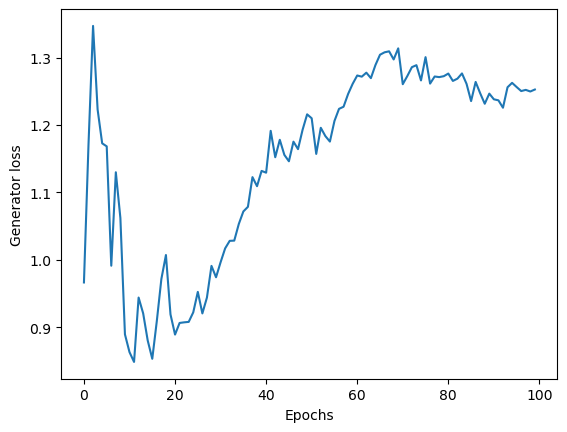

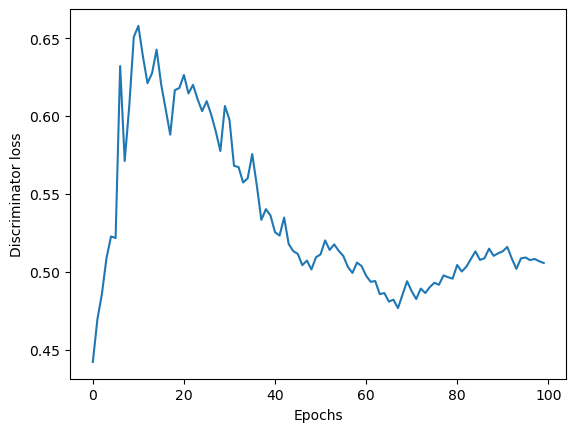

In [15]:
plt.plot(history.history['g_loss'])
plt.xlabel('Epochs')
plt.ylabel('Generator loss')
plt.show()
plt.plot(history.history['d_loss'])
plt.xlabel('Epochs')
plt.ylabel('Discriminator loss')
plt.show()

Using Conditional GANS to generate examples from class 1


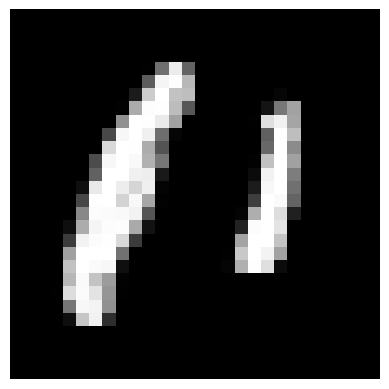

In [16]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

CLASS_TO_GENERATE= 1
NUM_EXAMPLES=128
DIM_IN_LATENT_SPACE=0

print('Using Conditional GANS to generate examples from class', CLASS_TO_GENERATE)
first_number = np.ones(NUM_EXAMPLES)*CLASS_TO_GENERATE

#Complete random generation of images
#non_latent_vectors = np.random.rand(batch_size, latent_dim)

#Moving from [-2,0,...,0] to [2,0,...,0] in the latent space
values=np.linspace(-2,2,NUM_EXAMPLES)
non_latent_vectors = np.zeros([NUM_EXAMPLES, latent_dim])
for i in range(NUM_EXAMPLES):
  non_latent_vectors[i,DIM_IN_LATENT_SPACE]=values[i]

GImages=trained_gen([non_latent_vectors,get_class_embedding(first_number)])
#@title
camera = Camera(plt.figure())
for classstep in range(0, GImages.shape[0]):
  plt.imshow(GImages[classstep])
  plt.axis('off')
  camera.snap()
save_animation('generated'+str(CLASS_TO_GENERATE)+'.mp4')

In [17]:
show_video('generated'+str(1)+'.mp4')

Questions:

1. According to the loss function curves, has the model converged to its optimal value?

2. Use the generator (cond_gan.generator) to produce new images for the number 7.

3. Use the generaror (cond_gan.generator) to produce new images for interpolation between number 6 and the number 8.
